In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import itertools

import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
results = pd.read_csv("metrics.csv")

dataf = results[results["algo"] == "datafly"]
mondr = results[results["algo"] == "mondrian"]
dataf_shuff = results[results["algo"] == "datafly_shuffled"]

In [3]:
results

,algo,no,precision,dm,cm,entropy,discern,ilm,lr_acc,auroc,hellinger,bivariate_corr
0,datafly,2,0.033311,0.0800,0.397432,0.976796,0.540324,0.046488,0.568243,0.579561,0.494021,0.123255
1,datafly_shuffled,2,0.025027,0.0325,0.433784,0.972464,0.336206,0.049454,0.515541,0.547946,0.495795,0.000000
2,mondrian,2,0.410685,0.5875,0.235405,0.819110,0.000530,0.045995,0.609459,0.722267,0.501421,0.005020
3,datafly,3,0.016667,0.0300,0.425811,0.992277,0.865115,0.048374,0.567568,0.572193,0.495795,0.000000
4,datafly_shuffled,3,0.033333,0.0500,0.389730,0.940804,0.096205,0.048419,0.530405,0.641823,0.495795,0.001459
...,...,...,...,...,...,...,...,...,...,...,...,...
592,datafly_shuffled,199,0.033333,0.0500,0.396216,0.946311,0.137907,0.048051,0.553378,0.589824,0.494021,0.001711
593,mondrian,199,0.418665,0.6075,0.262568,0.819337,0.000522,0.047188,0.599324,0.756438,0.495744,0.004173
594,datafly,200,0.025017,0.0325,0.382838,0.988104,0.755179,0.048139,0.607432,0.611960,0.495795,0.000000
595,datafly_shuffled,200,0.033324,0.0825,0.365135,0.949093,0.159284,0.047892,0.556081,0.645159,0.495795,0.123678


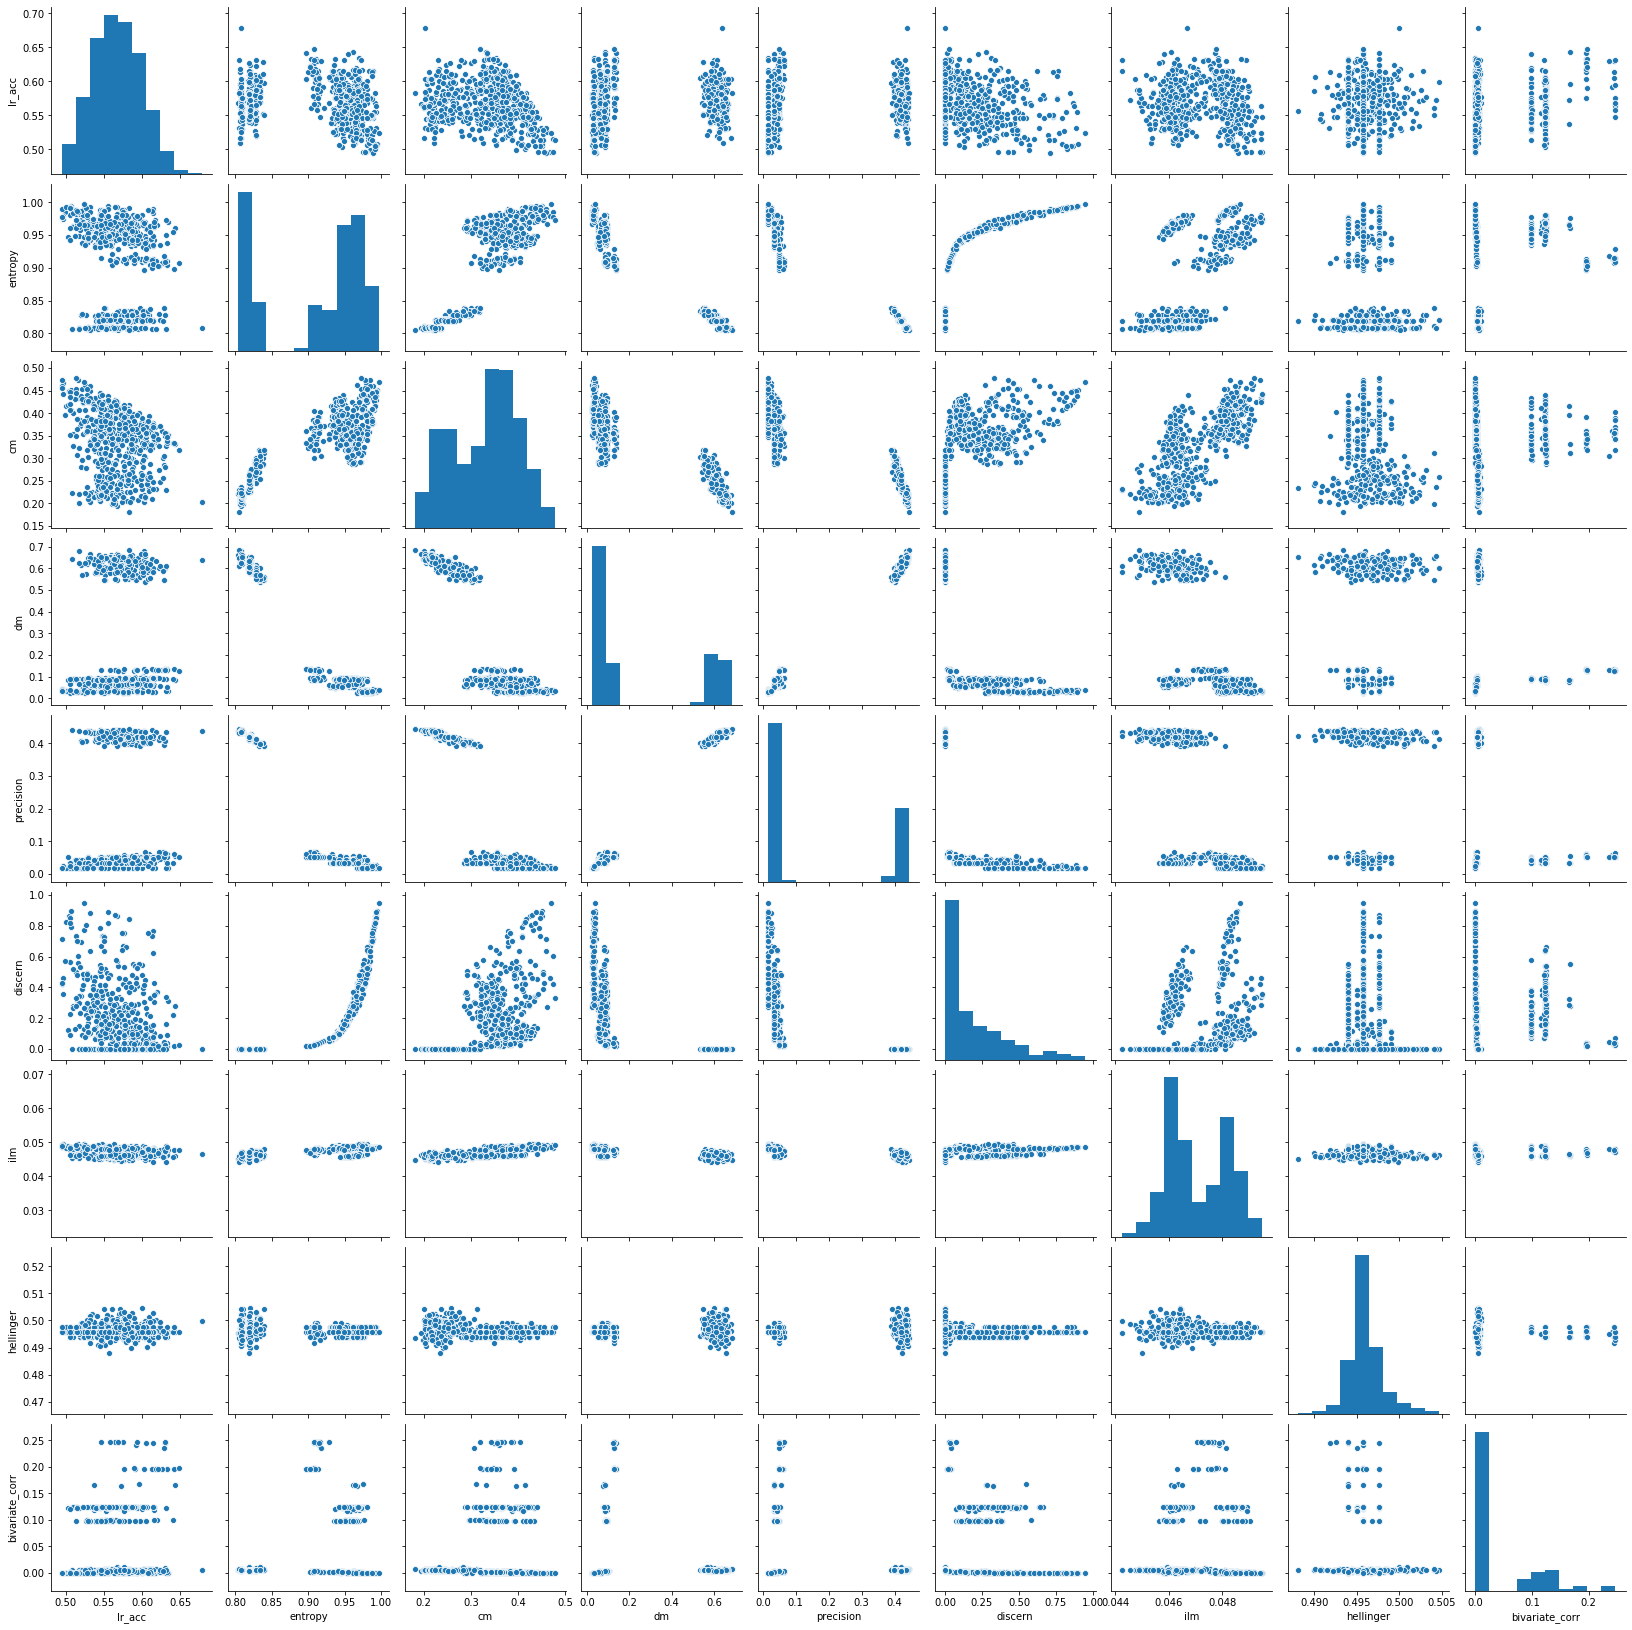

In [4]:
sb.pairplot(results[["lr_acc", "entropy", "cm", "dm", "precision", "discern", "ilm", "hellinger", "bivariate_corr"]])

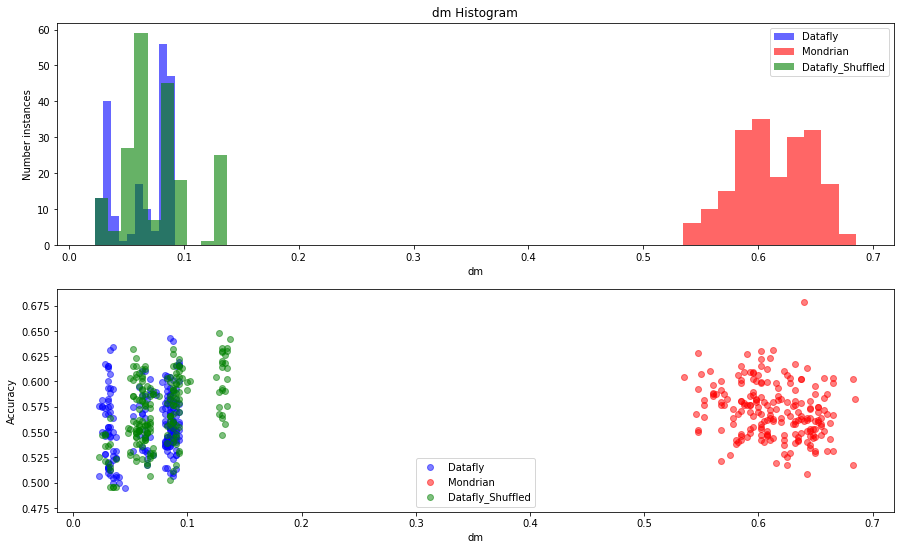

In [5]:
def plot_metric(metric):    
    fig, (ax1, ax2)= plt.subplots(2,1, figsize=(15,9))
    dataflys = results[results["algo"] == "datafly"]
    dataflys_shuff = results[results["algo"] == "datafly_shuffled"]
    mondrians = results[results["algo"] == "mondrian"]
    
    ax1.hist(dataflys[metric], label="Datafly", color="b", alpha=.6)
    ax1.hist(mondrians[metric], label="Mondrian", color="r", alpha=.6)
    ax1.hist(dataflys_shuff[metric], label="Datafly_Shuffled", color="g", alpha=.6)
    ax1.set_xlabel(metric)
    ax1.set_ylabel("Number instances")
    ax1.legend()
    ax1.set_title(f"{metric} Histogram")
    
    ax2.scatter(dataflys[metric], dataflys["lr_acc"], c="b", alpha=0.5, label="Datafly")
    ax2.scatter(mondrians[metric], mondrians["lr_acc"], c="r", alpha=0.5, label="Mondrian")
    ax2.scatter(dataflys_shuff[metric], dataflys_shuff["lr_acc"], c="g", alpha=0.5, label="Datafly_Shuffled")
    ax2.set_xlabel(metric)
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    
plot_metric("dm")

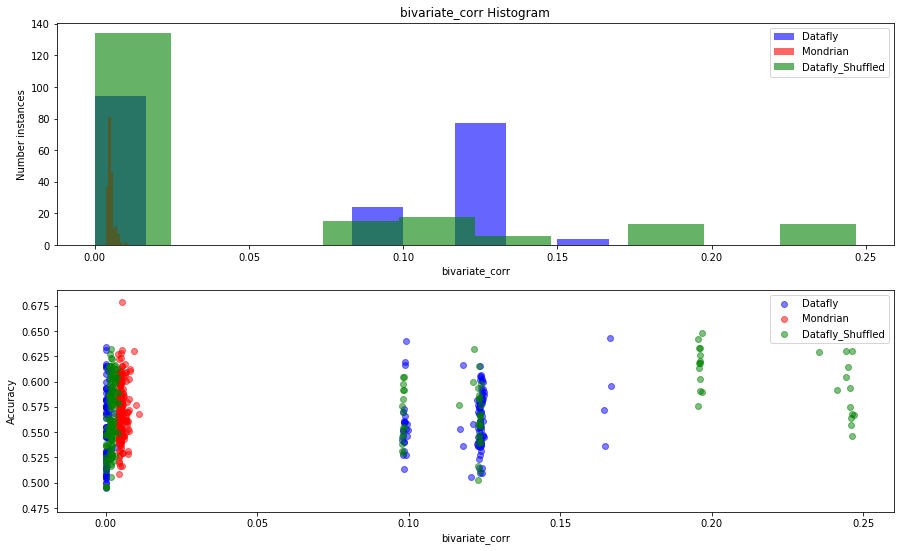

In [6]:
plot_metric("bivariate_corr")

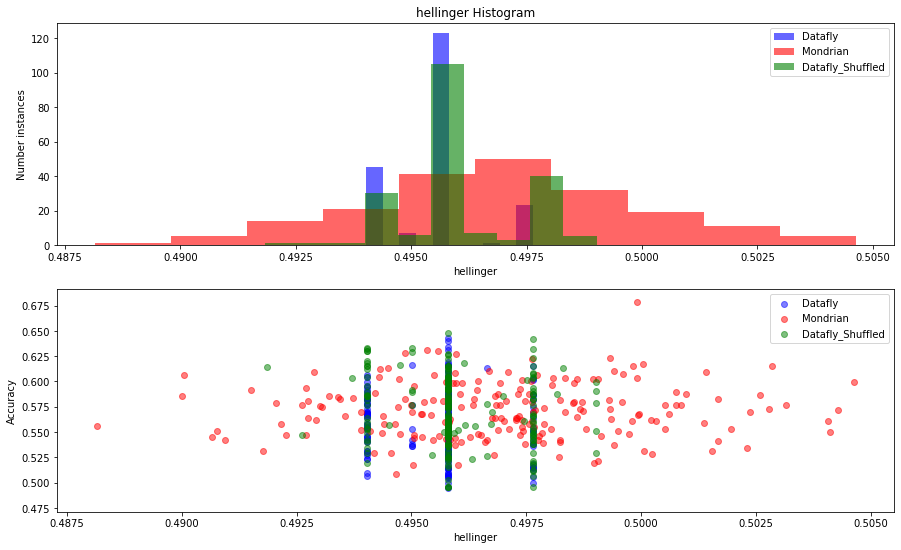

In [6]:
plot_metric("hellinger")

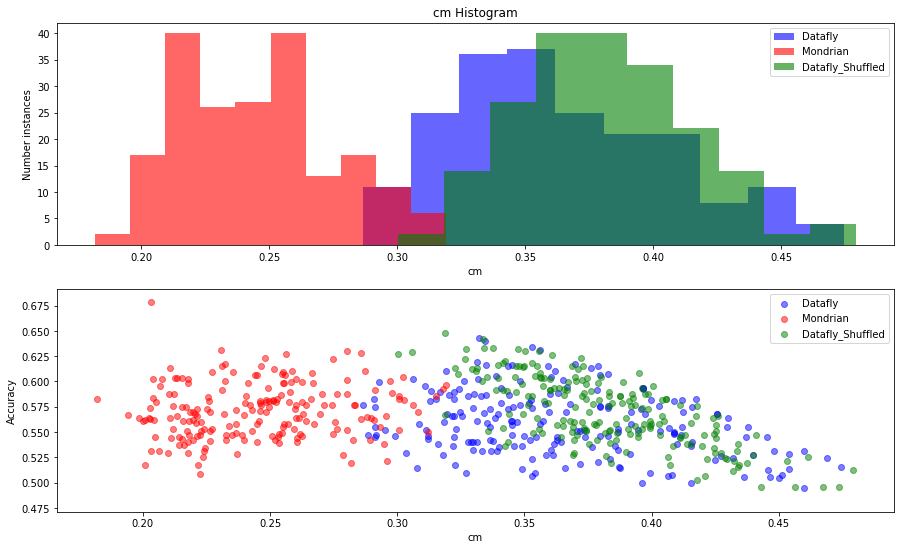

In [6]:
plot_metric("cm")

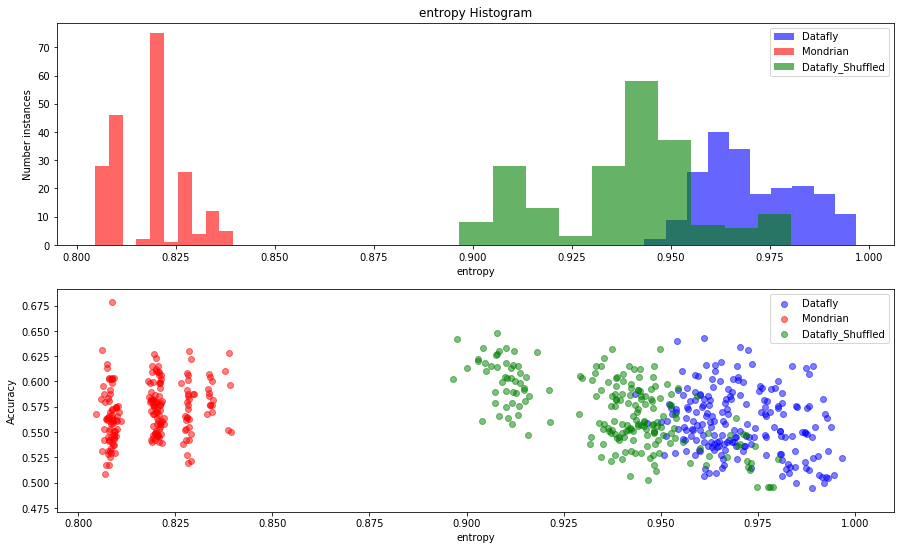

In [7]:
plot_metric("entropy")

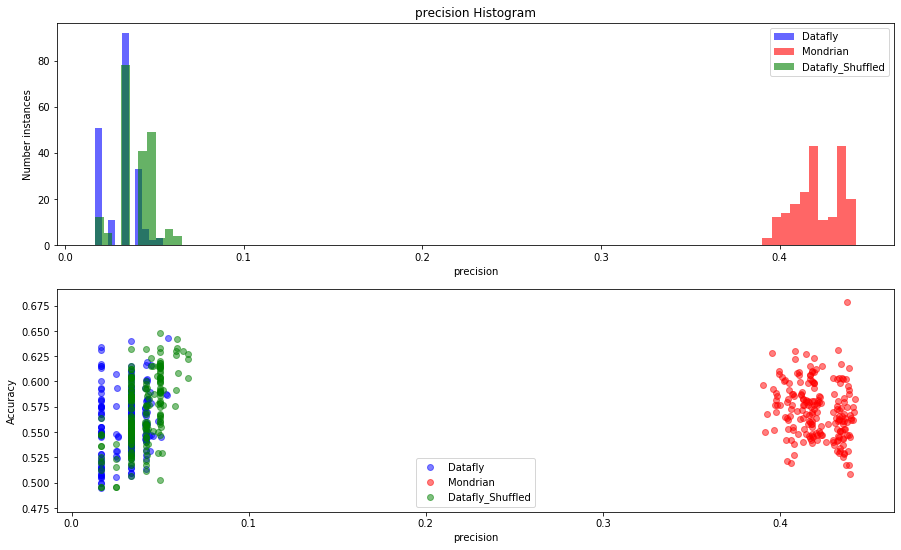

In [8]:
plot_metric("precision")

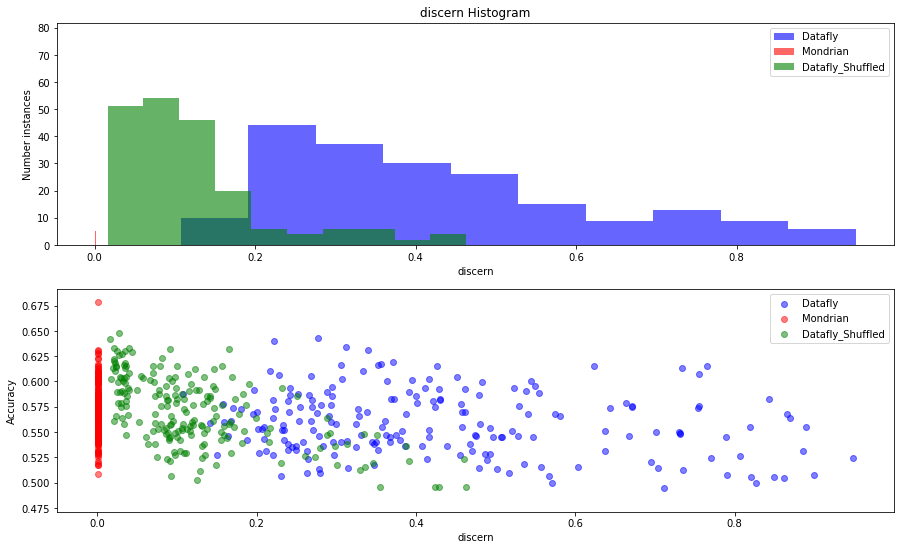

In [9]:
plot_metric("discern")

In [10]:
mondr["discern"].value_counts()

0.000335    5
0.000335    5
0.000334    4
0.000335    3
0.000334    3
           ..
0.000721    1
0.000711    1
0.000521    1
0.000722    1
0.000910    1
Name: discern, Length: 152, dtype: int64

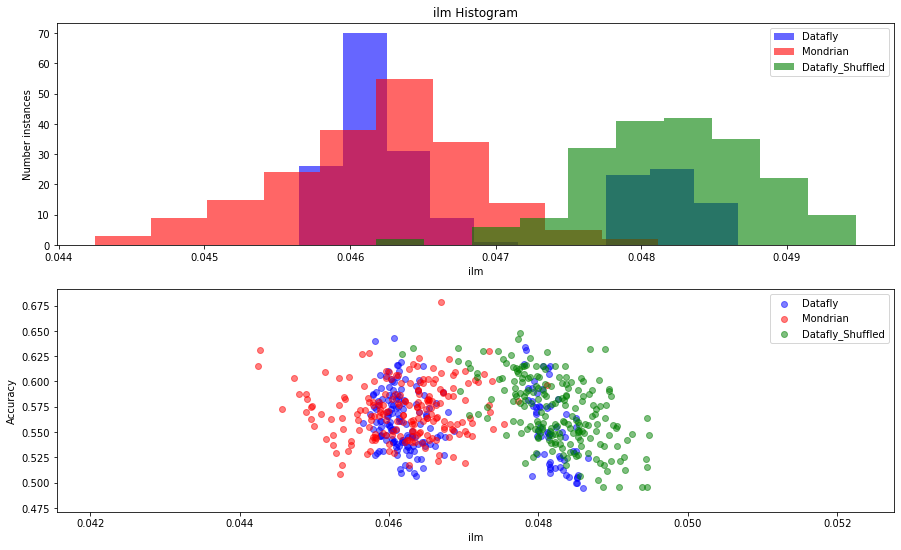

In [11]:
plot_metric("ilm")

# Plot AUROC

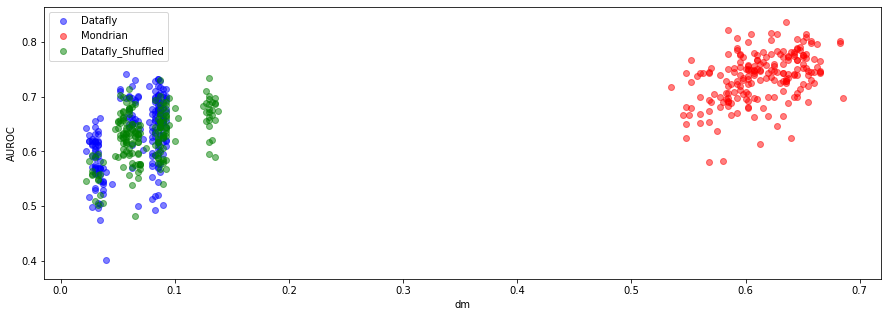

In [27]:
def plot_metric_auroc(metric):    
    fig, (ax2)= plt.subplots(1,1, figsize=(15,5))
    dataflys = results[results["algo"] == "datafly"]
    dataflys_shuff = results[results["algo"] == "datafly_shuffled"]
    mondrians = results[results["algo"] == "mondrian"]

    ax2.scatter(dataflys[metric], dataflys["auroc"], c="b", alpha=0.5, label="Datafly")
    ax2.scatter(mondrians[metric], mondrians["auroc"], c="r", alpha=0.5, label="Mondrian")
    ax2.scatter(dataflys_shuff[metric], dataflys_shuff["auroc"], c="g", alpha=0.5, label="Datafly_Shuffled")
    ax2.set_xlabel(metric)
    ax2.set_ylabel("AUROC")
    ax2.legend()
    
plot_metric_auroc("dm")

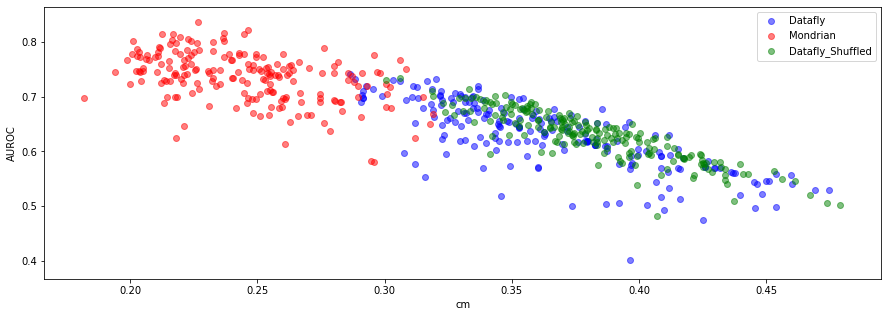

In [28]:
plot_metric_auroc("cm")

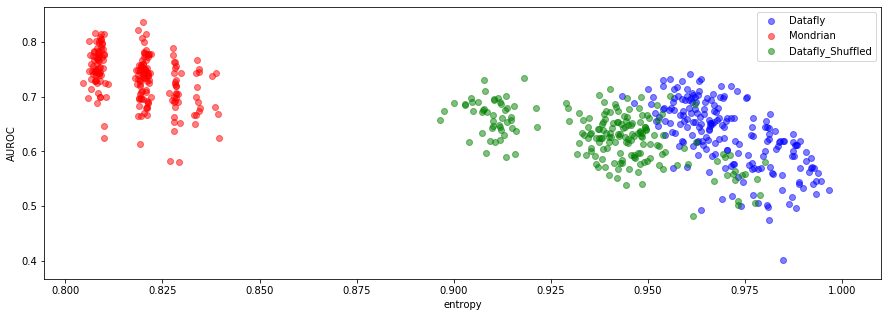

In [29]:
plot_metric_auroc("entropy")

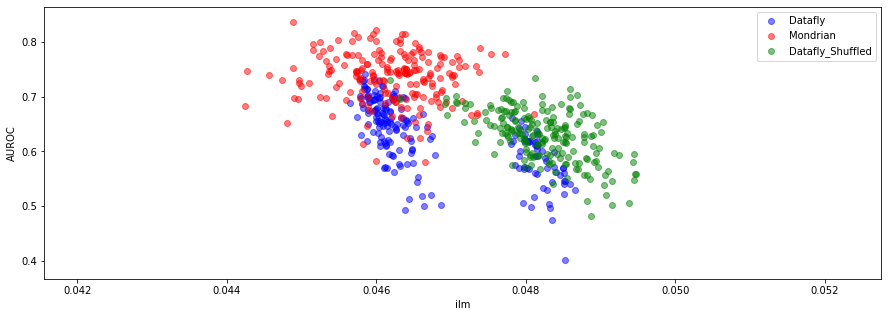

In [30]:
plot_metric_auroc("ilm")

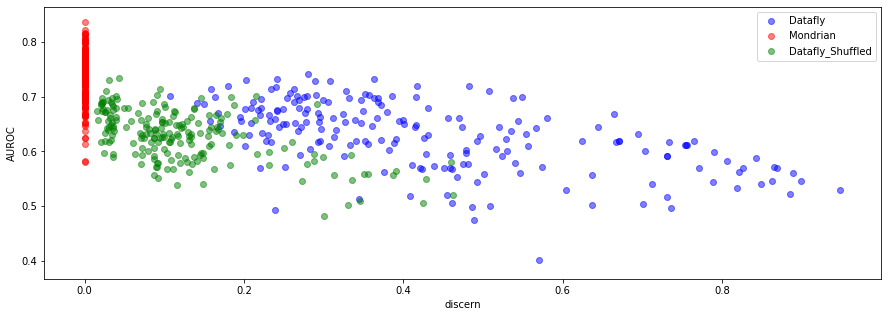

In [31]:
plot_metric_auroc("discern")

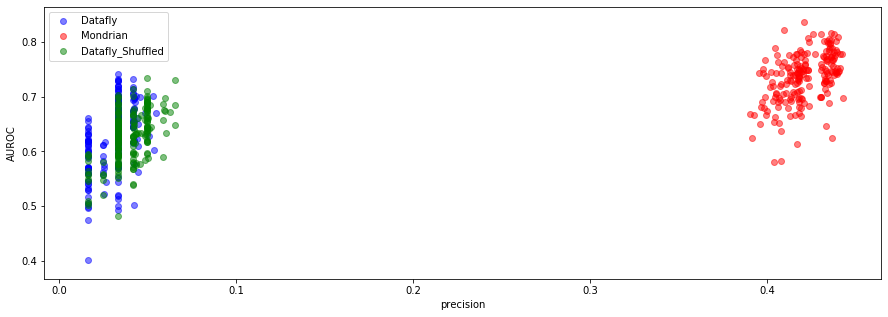

In [32]:
plot_metric_auroc("precision")

# Predicting Power

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def regress(regressor, algo_data):

    X = algo_data[regressor]
    y = algo_data["lr_acc"]

    reg = LinearRegression()
    reg.fit(X, y)

    score = reg.score(X,y)
    return reg, score

def mse(reg, attributes):
    attrs = np.array(results[attributes])
    attrs = attrs.reshape(-1,1) if len(attrs) == 1 else attrs
    y_pred = reg.predict(attrs)
    y_true = results["lr_acc"]
    mse = mean_squared_error(y_true, y_pred)
    return mse

mses = []

In [13]:
def fit_and_graph(regressor, algo_data):
    print(f"Regression on {algo_data['algo'].iloc[0]}")
    reg, score = regress([regressor], algo_data)
    coeff = reg.coef_
    intercept = reg.intercept_
    
    err = mse(reg, [regressor])
    print(f"p-value: {scipy.stats.pearsonr(algo_data[regressor],algo_data['lr_acc'])[1]}")
    print(f"R2 Score: {score}")
    print(f"MSE: {err}")
    print(f"Coeffs: {coeff}")
    print(f"Intercept: {intercept}")
    
    x = np.linspace(0,1,100)
    l = coeff*x + intercept
    
    algo_data.plot.scatter(regressor, "lr_acc", figsize=(15,6), grid=True, 
                           title=f"Linear regression of the {regressor}({algo_data['algo'].iloc[0]})")
            
    plt.plot(x,l)
    


### Entropy

Regression on datafly
p-value: 0.0006604960452570874
R2 Score: 0.057310319332110615
MSE: 0.0031817415364947133
Coeffs: [-0.63067508]
Intercept: 1.1708622857514845

Regression on mondrian
p-value: 0.0032607844850511126
R2 Score: 0.043091698407010104
MSE: 0.0068794154789237226
Coeffs: [0.62115088]
Intercept: 0.0630021271469896

Regression on datafly_shuffled
p-value: 1.0796300157025528e-24
R2 Score: 0.4146425301085469
MSE: 0.007316754376354911
Coeffs: [-1.14742397]
Intercept: 1.6471173895179623


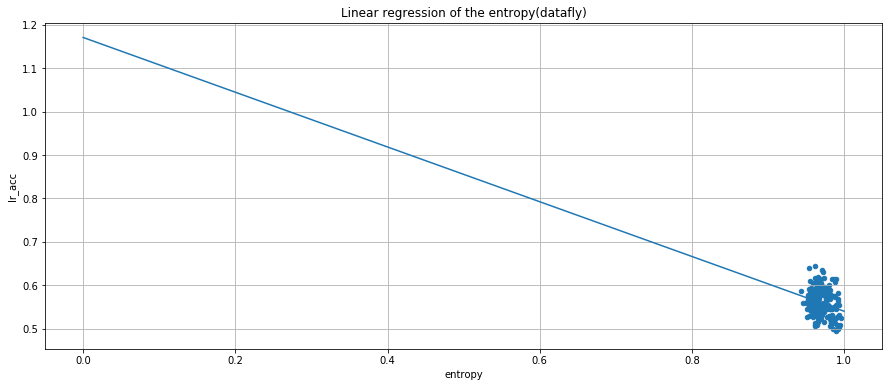

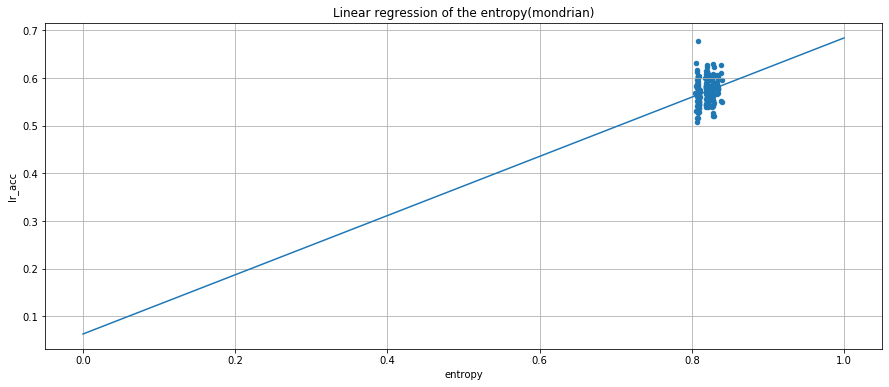

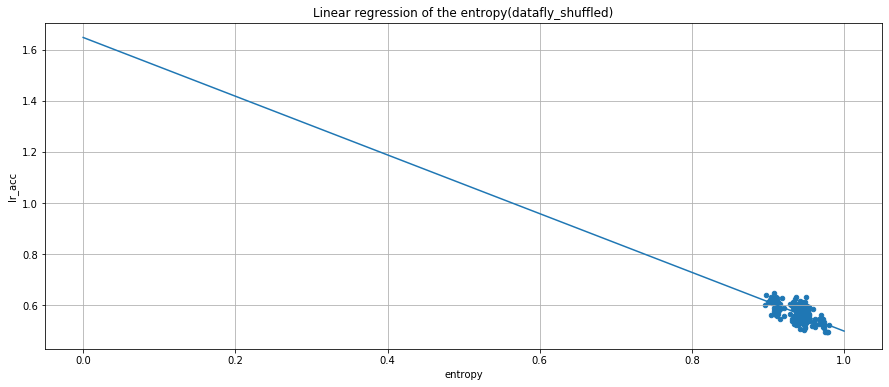

In [14]:
fit_and_graph("entropy", dataf)
print()
fit_and_graph("entropy", mondr)
print()
fit_and_graph("entropy", dataf_shuff)

### Classification Metric

Regression on datafly
p-value: 1.7421366883052236e-06
R2 Score: 0.10982226495653491
MSE: 0.0010074458243631485
Coeffs: [-0.24281992]
Intercept: 0.647250698268545

Regression on mondrian
p-value: 0.07779454339146735
R2 Score: 0.015704212153204833
MSE: 0.0013487012398551291
Coeffs: [0.11186326]
Intercept: 0.5437860188262433

Regression on datafly_shuffled
p-value: 5.128577163986909e-34
R2 Score: 0.5287046913812229
MSE: 0.0045023508313123016
Coeffs: [-0.73104551]
Intercept: 0.849482749617366


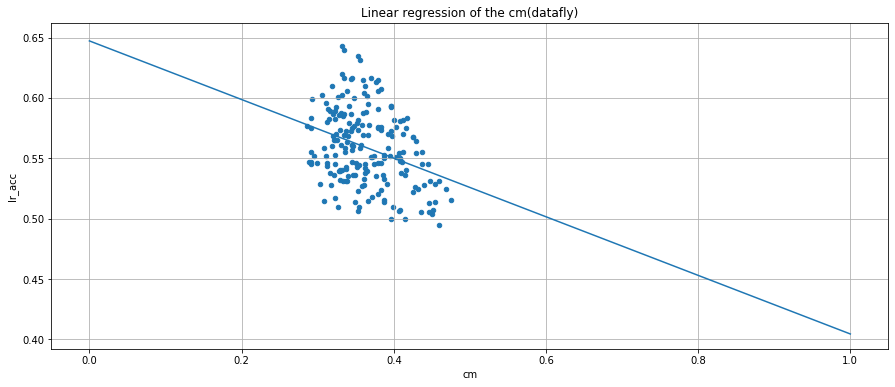

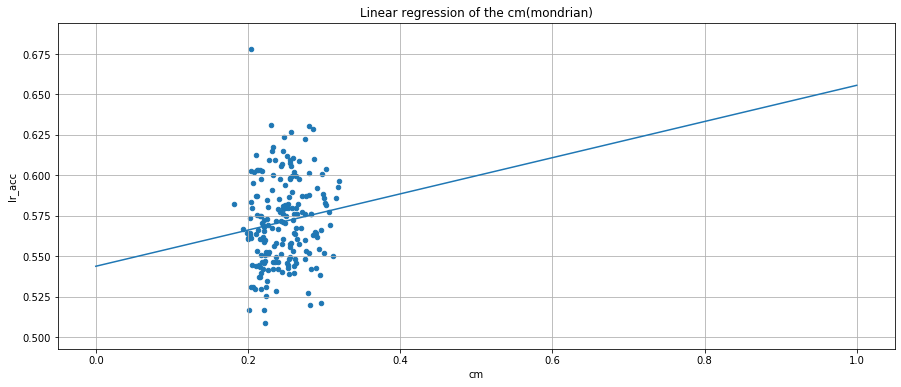

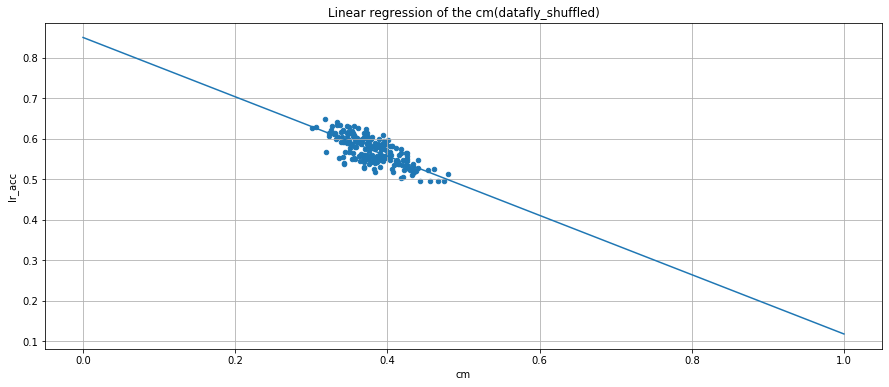

In [15]:
fit_and_graph("cm", dataf)
print()
fit_and_graph("cm", mondr)
print()
fit_and_graph("cm", dataf_shuff)

### DM

Regression on datafly
p-value: 0.10414245521086343
R2 Score: 0.013349863486657119
MSE: 0.0025534268723020545
Coeffs: [0.1486852]
Intercept: 0.5491720346418423

Regression on mondrian
p-value: 0.0018332972726046747
R2 Score: 0.04821007150852752
MSE: 0.008366395852821383
Coeffs: [-0.18120865]
Intercept: 0.6824306572835259

Regression on datafly_shuffled
p-value: 9.584228194103447e-15
R2 Score: 0.2630382764541265
MSE: 0.038747991615902075
Coeffs: [0.62621468]
Intercept: 0.5231576143066445


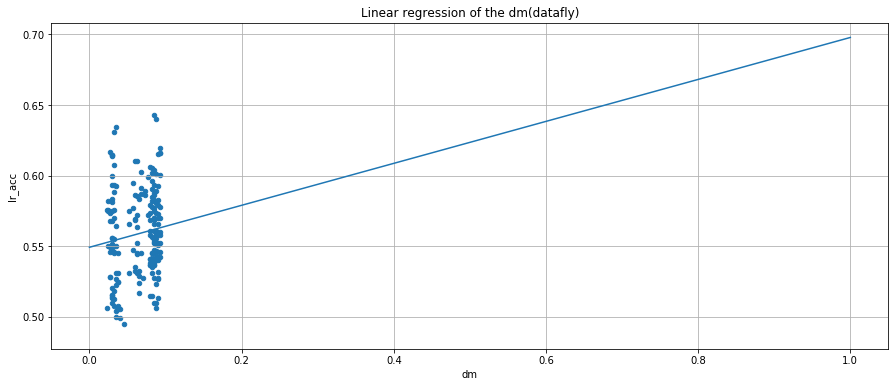

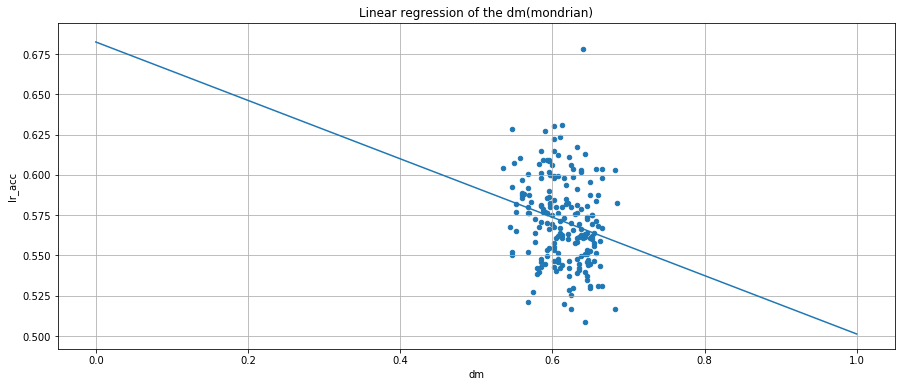

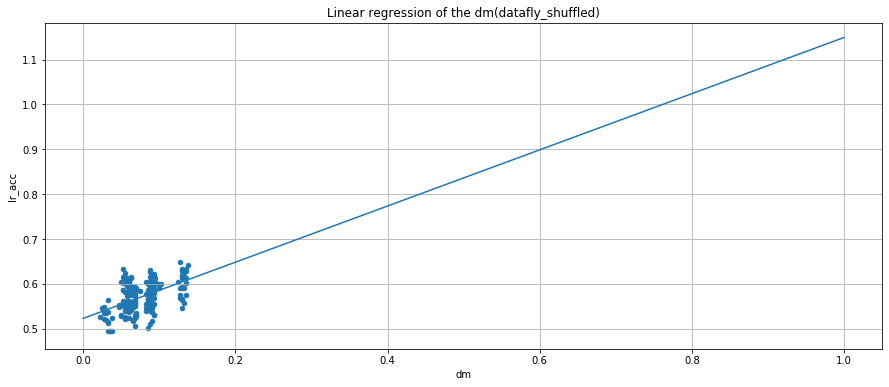

In [16]:
fit_and_graph("dm", dataf)
print()
fit_and_graph("dm", mondr)
print()
fit_and_graph("dm", dataf_shuff)

### Precision


Regression on datafly
p-value: 0.00951617825390614
R2 Score: 0.033636160949336746
MSE: 0.016824134329269005
Coeffs: [0.59154353]
Intercept: 0.5405818517341071

Regression on mondrian
p-value: 0.002985867577362808
R2 Score: 0.04387344586120767
MSE: 0.020598963240339576
Coeffs: [-0.42733634]
Intercept: 0.751170870524435

Regression on datafly_shuffled
p-value: 1.6844911544536e-17
R2 Score: 0.3084652576759759
MSE: 0.15850671749393172
Coeffs: [1.80378671]
Intercept: 0.49900914751973763


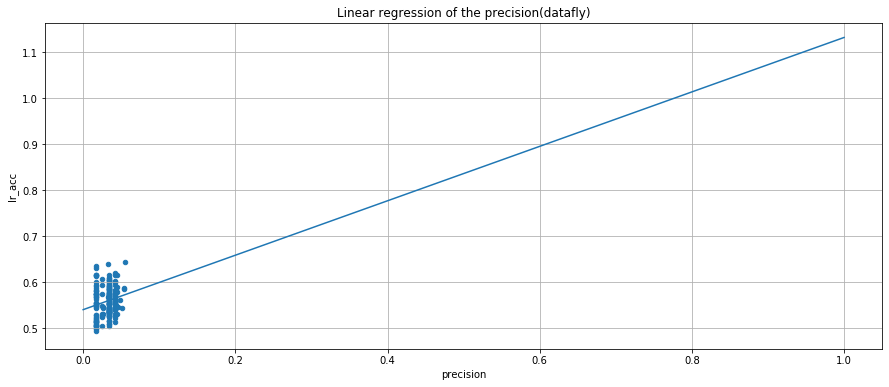

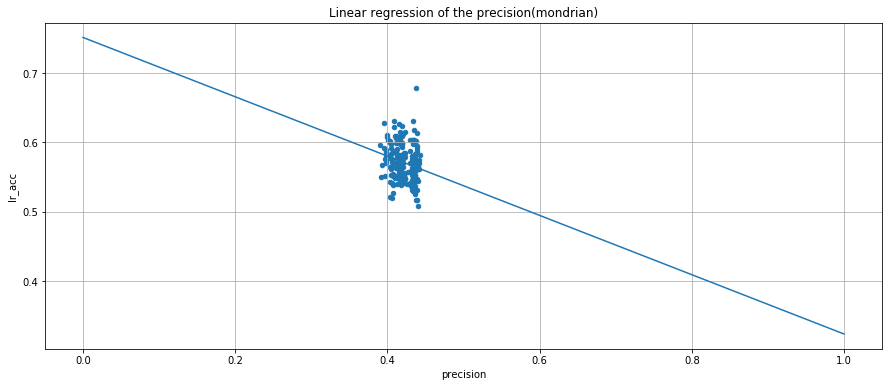

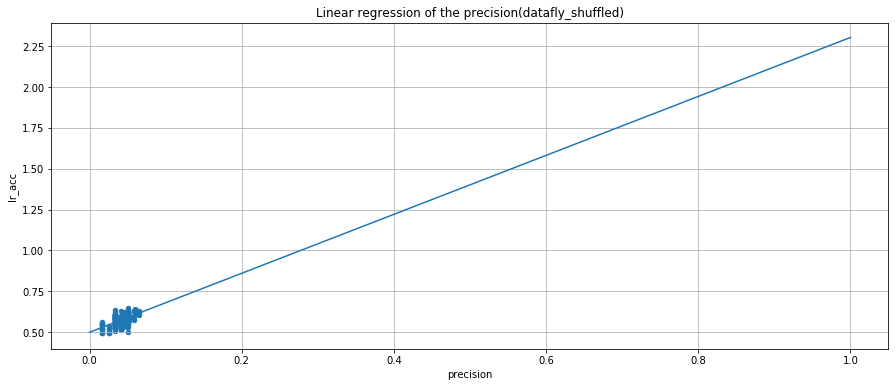

In [17]:
fit_and_graph("precision", dataf)
print()
fit_and_graph("precision", mondr)
print()
fit_and_graph("precision", dataf_shuff)


### Discernability

Regression on datafly
p-value: 0.003544618284691476
R2 Score: 0.042351356423284914
MSE: 0.0008962262363389485
Coeffs: [-0.03292797]
Intercept: 0.5728838438991037

Regression on mondrian
p-value: 0.002507691898626356
R2 Score: 0.04542379598470159
MSE: 71.7396200572585
Coeffs: [29.7541675]
Intercept: 0.5557721304645314

Regression on datafly_shuffled
p-value: 5.1020526570807774e-20
R2 Score: 0.3476225238048578
MSE: 0.0023729419757252887
Coeffs: [-0.21386711]
Intercept: 0.5968924572180073


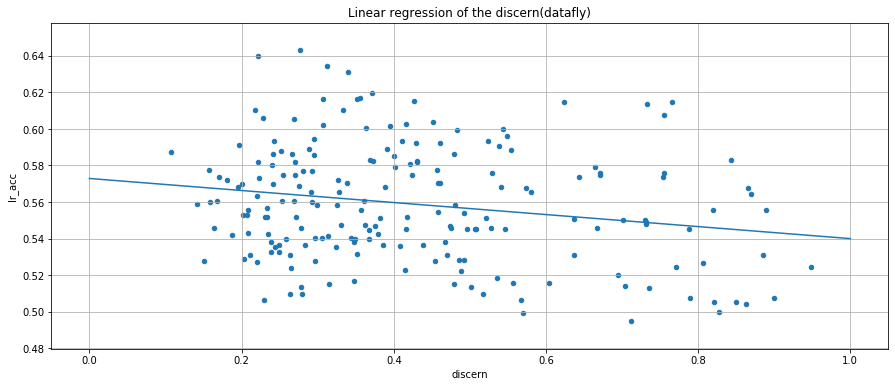

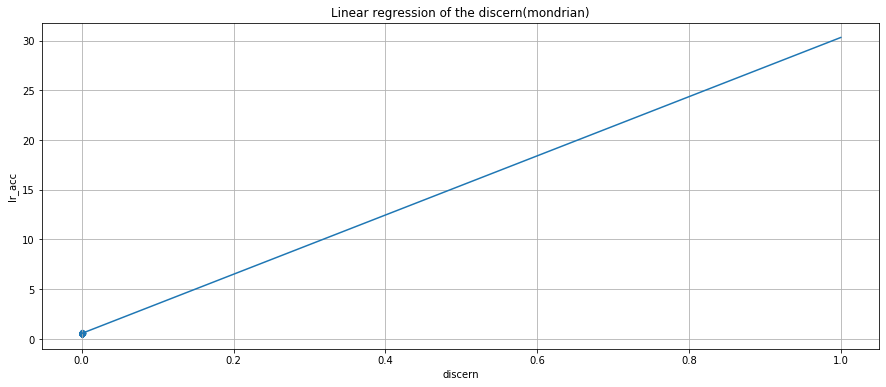

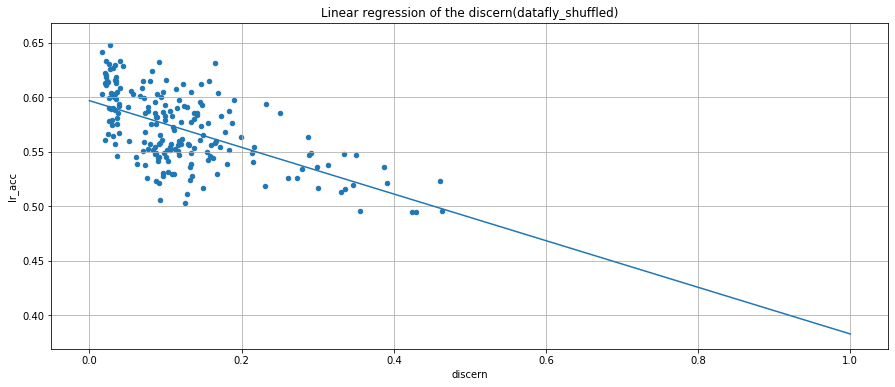

In [18]:
fit_and_graph("discern", dataf)
print()
fit_and_graph("discern", mondr)
print()
fit_and_graph("discern", dataf_shuff)

### Information Loss Metric

Regression on datafly
p-value: 0.0012131227281975045
R2 Score: 0.05188828676601709
MSE: 0.0010842691786009959
Coeffs: [-7.42117358]
Intercept: 0.9060645660159501

Regression on mondrian
p-value: 0.4467064216263941
R2 Score: 0.002942192561700474
MSE: 0.0010442645270954697
Coeffs: [2.21981843]
Intercept: 0.4687371067854119

Regression on datafly_shuffled
p-value: 2.481821386781078e-18
R2 Score: 0.32164070667996303
MSE: 0.0038609032629159257
Coeffs: [-33.17063458]
Intercept: 2.170299957716591


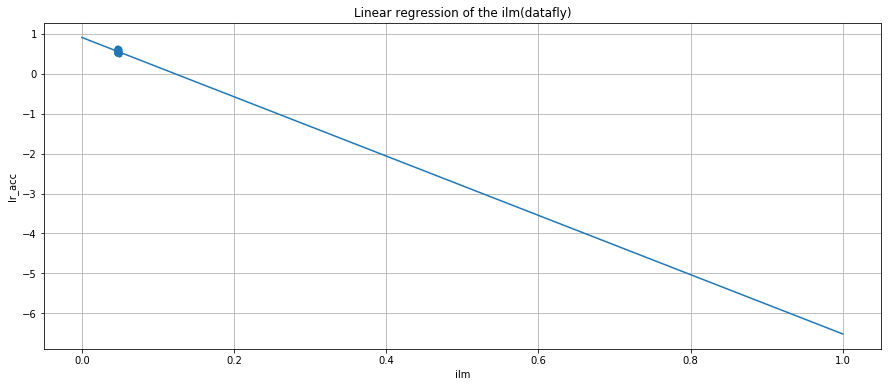

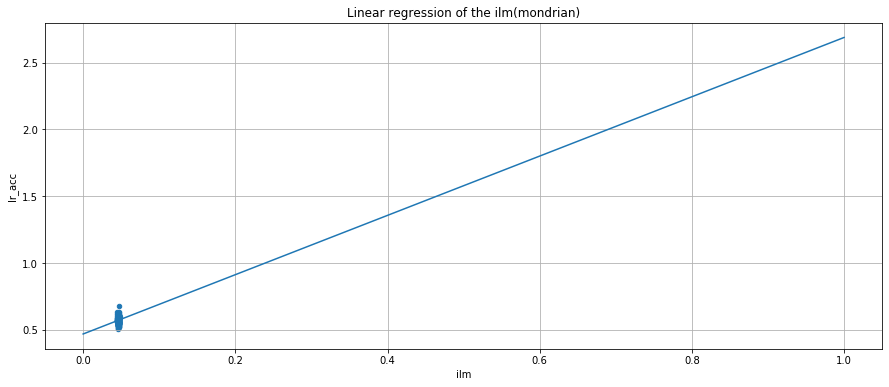

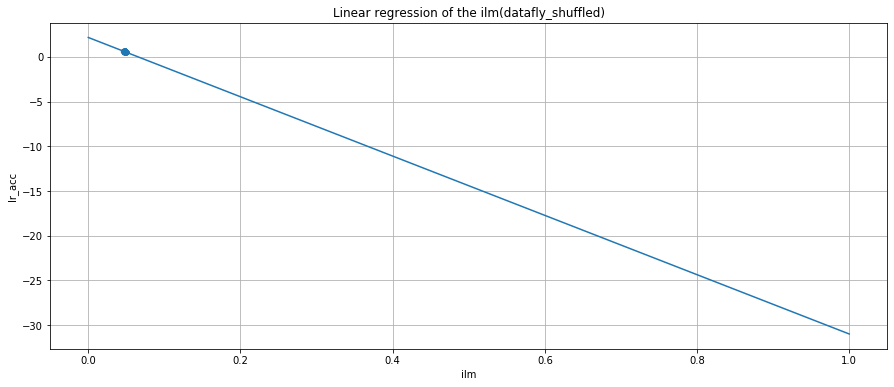

In [19]:
fit_and_graph("ilm", dataf)
print()
fit_and_graph("ilm", mondr)
print()
fit_and_graph("ilm", dataf_shuff)

### Multiple Metrics

In [20]:
metrics = ["entropy", "cm", "dm", "precision", "discern", "ilm"]

res = []
for i in range(1,6):
    
    for comb in itertools.combinations(metrics, i):
        
        ms = list(comb)
        for alg in [dataf, mondr, dataf_shuff]:
            name = alg["algo"].iloc[0] 
            reg, score = regress(ms, alg)
            err = mse(reg, ms)
            p_val = scipy.stats.pearsonr(alg[ms[0]], alg['acc'])[1] if i == 1 else None
            res.append((str(ms), name, p_val, score, err))

            
df = pd.DataFrame(res, columns=["metrics", "algo", "p_value", "R2_score", "MSE_error"])
df = df.set_index(["metrics", "algo"])
df.head(20)

p_value  R2_score  MSE_error
metrics           algo                                               
['entropy']       datafly           3.982339e-07  0.057310   0.003182
                  mondrian          2.641115e-01  0.043092   0.006879
                  datafly_shuffled  1.046904e-08  0.414643   0.007317
['cm']            datafly           5.254540e-02  0.109822   0.001007
                  mondrian          1.432585e-01  0.015704   0.001349
                  datafly_shuffled  5.193489e-05  0.528705   0.004502
['dm']            datafly           4.600207e-01  0.013350   0.002553
                  mondrian          3.871429e-01  0.048210   0.008366
                  datafly_shuffled  5.204212e-02  0.263038   0.038748
['precision']     datafly           3.032515e-01  0.033636   0.016824
                  mondrian          1.824561e-01  0.043873   0.020599
                  datafly_shuffled  1.362340e-02  0.308465   0.158507
['discern']       datafly           3.736657e-07  0.042351   0.000896
                  mondrian          3.088057e-01  0.045424  71.739620
                  datafly_shuffled  1.315992e-07  0.347623   0.002373
['ilm']           datafly           1.422017e-02  0.051888   0.001084
                  mondrian          4.509778e-01  0.002942   0.001044
                  datafly_shuffled  2.187764e-06  0.321641   0.003861
['entropy', 'cm'] datafly                    NaN  0.110170   0.001096
                  mondrian                   NaN  0.069385   0.028048